# df from IQ
Vance Wheeler Apr 12 2023

Neatly writing functions to perfrom the phase fit to find df described by Barry and Gao, which were mostly figured out in the notebook iq_processing_test. Also fully realize the interpolation of $freq(\phi)$, and how to save these params to apply to the actual timestream data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',size=14)
import scipy.optimize
import scipy.interpolate
import fnmatch

### Reference to some data structure:
https://docs.google.com/document/d/1fpIM2Ms6trL3FTHMXGxvsUr0tChEAcY2m36WbCwg0Ks/edit , written by Kirit (I think) and describes some parts of the analysis pipeline.

# Sweep Data

Need to take a look at the sweep and sweep reduc (reduced) data that is in these directories to see which goes to which, which has the info I want

The associated frequency sweep for a given data stream (or batch of them for a given calibration) is NOT given in the spreadsheet that accompanied the data, nor apparently in the data itself in this format.

Some of the dirfiles in the original format have subdirectories with a sweep reduc associated, but not all. So even this is utterly unclear. The doc linked above notes that there will need to be a sweep preceding each run, so I guess for now I can just correlate the timestamp in the file name for data to the preceding sweep and call that good enough?

bb stands for baseband frequencies, where lo is local oscillator according to Tyler (not described at all in the doc)

Sweep reduc are described as being created from the sweep files, and are probably the thing I need which averages and distills sweep data to some degree.

__Use the fields Kxxx from Elly's converted sweep reduc files__

This contains the averaged sweep data for each freq bin, and has not yet been fit/rotated, so is a bit less processed.

In [103]:
# Path to data that Tyler converted
#path_srd_t = "C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/from_tyler_Vance_pol_data/20221221_193904_sweep_reduc.npy"
# read the numpy file
#data_t = np.load(path_srd_t,allow_pickle=True,encoding='latin1')# this ends up saved as 0D np array, when is native
                                                                      #  dict. use .item() to recover the dict within
# Path to data that Elyssa converted
#path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_apr_4_2023/ft85_converted/20230404_212127_sweep_reduc.npz"
path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/converted_mar_2023/20230315_224543_sweep_reduc.npz"
# read the compressed numpy file (much nicer format, requires no extra args)
data_srd = np.load(path_srd,allow_pickle=True,encoding='latin1')
  
print(type(data_srd))
    
keys_srd = []
for k in data_srd.keys():
    keys_srd.append(k)
    
keys_srd = np.sort(keys_srd) # read from npy files in however Tyler did this conversion, keys are not sorted, this is all just to do that
print(keys_srd)

<class 'numpy.lib.npyio.NpzFile'>
["b'INDEX'" "b'K013'" "b'K014'" "b'K015'" "b'K016'" "b'K017'" "b'K018'"
 "b'K019'" "b'K020'" "b'bb_freqs'" "b'caldata.K013'" "b'caldata.K014'"
 "b'caldata.K015'" "b'caldata.K016'" "b'caldata.K017'" "b'caldata.K018'"
 "b'caldata.K019'" "b'caldata.K020'" "b'calparam.didf0'"
 "b'calparam.didq2'" "b'calparam.dqdf0'" "b'calparam.f0s'"
 "b'calparam.i0'" "b'calparam.q0'" "b'lo_freqs'"]


In [4]:
for k in keys_srd: # look through for errors
    try:
        print('\n',k)
        print(data_srd[k]) # Quick look
    except Exception as e:
        print(type(e))
        pass


 b'INDEX'
[]

 b'K013'
[-1029874.125     +2475309.j      -1005681.9375    +2471125.5j
  -980824.75      +2466605.j       -956685.1875    +2462260.25j
  -932094.875     +2457103.25j     -906244.0625    +2450834.5j
  -880243.0625    +2444499.75j     -855409.75      +2437801.25j
  -830985.        +2430481.25j     -805585.25      +2422895.25j
  -780281.625     +2413886.75j     -755001.8125    +2405084.5j
  -729996.75      +2394507.75j     -704304.625     +2384440.25j
  -678765.4375    +2372187.j       -652550.8125    +2360420.5j
  -626478.875     +2345416.25j     -601018.3125    +2331410.j
  -576205.625     +2318520.5j      -551952.5       +2301496.75j
  -526975.        +2285138.j       -501592.75      +2266197.25j
  -476456.1875    +2248318.5j      -451758.5       +2227384.25j
  -428610.375     +2206926.5j      -404411.03125   +2186335.5j
  -380992.65625   +2166231.25j     -358477.6875    +2144236.25j
  -335326.375     +2121343.5j      -312311.59375   +2097311.75j
  -291016.875     +2070

In [106]:
# need to create a reference freq from here to verify with!
print(len(data_srd["b'lo_freqs'"]))
print(data_srd["b'bb_freqs'"]+data_srd["b'lo_freqs'"][int(len(data_srd["b'lo_freqs'"])/2)])
                               # note not all necessarily have 300 entries in freq space, or an even number!!!
                               #  would really love to see the damn reference f0 appear in all the data dude.

print(data_srd["b'calparam.f0s'"])

167
[1.54483705e+09 1.61258392e+09 1.61639682e+09 1.63275439e+09
 1.73876866e+09 1.76004896e+09 1.77510576e+09 1.78110387e+09]
[1.54483705e+09 1.61258392e+09 1.61639682e+09 1.63275439e+09
 1.73876866e+09 1.76004896e+09 1.77510576e+09 1.78110387e+09]


## Major breakthrough in understanding the file types of this shit

Look up the numpy docs on npy and npz in terms of np.save and np.savez. Rather than trying to recover dictionaries using keys() (and I have no clue how Elyssa's npz repsonds to that method call, I can't get mine to, calling .files attribute is the real thing to do and works for both Tyler and Elyssa's format.

For whatever reason both Tyler and Elyssa have their keys in an explcit byte string in this case therefore, so I won't need to do double duty on treating them differently just in case.

In [388]:
print(data_t["b'bb_freqs'"])

[-51613138. -50175237. -41331122. -39382411. -27950266. -22902092.
 -12543070.  15088209.  19132961.  24065269.  29871925.  38632011.
  43171396.  53947715.]


# Apr 11 Onward

Need to get serious on codifying this stuff into some functions and moving it to another notebook. Make and do some quick testing of the funcs here

## Define Functions

In [3]:
def find_sweep(infile): # Given a data file find the sweep file that corresponds, probably put in a prompt where it
    # asks the user for the path if it cannot find it or is unsure.
    return swfile

In [4]:
def read_sweep(swfile): # simply read the sweep data
    # call find_sweep? Then read the file it produces - or seperate to just do with the output of find_sweep,
    #  for now just assume it takes specified infile
    
    # this is fine for now, but see above markdown cell for reasons why this is overkill and I could just be using
    #  the .file attribute to find the "keys" for a numpy file.
    
    # read data
    data_in = np.load(swfile,allow_pickle=True,encoding='latin1') # extra args needed in case of Tyler's conversion
                                                                  # in case of Elyssa's, not needed
    try: data_in.keys() # check to make sure the input is dict like, if not, could be 0d array,
    except AttributeError:
            data_in = data_in.item() # use .item() to recover dict within
            pass
    
    # check if keys are standard string or bytes, assign string start appropriately
    if list(data_in.keys())[0][:2] == "b'": strt = "b'"
    else: strt = ""
    
    # find kid channel freqs
    #  use fnmatch to search keys with wildcard since end may/may not have ' in the string
    lo = data_srd[fnmatch.filter(data_srd.keys(),strt+"lo_freqs*")[0]] # local oscillator freqs
    bb = data_srd[fnmatch.filter(data_srd.keys(),strt+"bb_freqs*")[0]] # baseband freq, each index corresponds to one channel
    
    sw_freq = [b + lo for b in bb] # create single array for freqs of size n channels, freq.
                                  #  less mem efficient, but simpler
    
    # find kid channel IQ data
    chan_keys = fnmatch.filter(data_in.keys(),strt+"K*") # for now I assume this is sorted automatically
    
    kidno = []
    sw_iq=[]
    for k in chan_keys:    
        kk = k.split("'")
        if len(kk) > 1: kidno.append(kk[1]) # if there is ' in the str, take the part between them
        else: kidno.append(kk[0]) # otherwise just take the whole value

        sw_iq.append(data_in[k])

    
    return np.array(kidno),np.array(sw_freq),np.array(sw_iq)

In [5]:
# test output:
kidno,freq,sw_iq = read_sweep(path_srd)

NameError: name 'path_srd' is not defined

In [5]:
def line(x,m,b): # Simple linear fit func
    return m*x + b

In [76]:
def cable_fit(sw_freq,sw_iq): # this fits the cable delay to produce the parameter needed to circularize

    pointno = 30 # number of points on each end of the array to fit

    # find and unwrap phase:
    phi = np.arctan2(np.imag(sw_iq),np.real(sw_iq))
    phi = unwrap(phi)

    slope =[]
    for i in range(len(phi)):

        # fit linear model to phase(f) to first and last pointno points
        ## should get a way to estimate p0

        popt_lo,pcov_lo = scipy.optimize.curve_fit(line,sw_freq[i,:pointno],phi[i,:pointno],p0=[1e-7,1e3]) # lo freq end
        popt_hi,pcov_hi = scipy.optimize.curve_fit(line,sw_freq[i,-pointno:],phi[i,-pointno:],p0=[1e-7,1e3]) # high freq end

        # average the 2 models to find slope, intercept doesn't matter, const phase offset
        #  will be accounted in later processing

        slope.append((popt_lo[0]+popt_hi[0])/2)

    return np.array(slope)


In [8]:
# test output
slope = cable_fit(freq,sw_iq)
#print(slope)

NameError: name 'freq' is not defined

In [7]:
def circularize(freq_in,iq_in,slope):
    
    # Correct phase by the slope caused primarily by cable delay
    circ_iq =[]
    for i in range(len(iq_in)):
        phi = np.arctan2(np.imag(iq_in[i]),np.real(iq_in[i]))
        mag = np.absolute(iq_in[i])
        
        # apply correction
        phi = phi - slope[i]*freq_in[i]
    
        # convert back to complex
        circ_iq.append(mag*np.cos(phi) + 1j*mag*np.sin(phi))
    
    return np.array(circ_iq)

In [210]:
# test output
circ_iq = circularize(freq,sw_iq,slope)

In [8]:
def get_center_simple(circ_iq): # this finds the center coords to be used for translation and rotation, needs circularized first
    # this is just super simple currently, as above taking the average of the max extents - can be changed later
    center = []
    for iq in circ_iq:
        xcen = (np.min(np.real(iq)) + np.max(np.real(iq)))/2
        ycen = (np.min(np.imag(iq)) + np.max(np.imag(iq)))/2
        
        # combine to single complex number again
        center.append(xcen + 1j*ycen)
    
    return np.array(center)

In [9]:
def fit_ellipse(x, y):
    """
    VW: From https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    VW: From https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi

def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    VW: From https://scipython.com/blog/direct-linear-least-squares-fitting-of-an-ellipse/
    
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

In [56]:
def get_center(circ_iq,kidno,full_output=False): # using ellipse fitting method from an article on scipython.org
    # full out prints all the params, used in case I want to plot the fitted ellipse.
    end_cut = 100 # cut this many points from either end of the IQ loop to remove the dense junk tails
                  #  and keep mostly just the actual loop. In future this can be improved by making cuts
                  #  for each data set based on point density or similar.
    ellicent = []
    elliparams = []
    
    for iq,kid in zip(circ_iq,kidno):
        print(kid)
        ellicoeffs = fit_ellipse(np.real(iq[end_cut:-end_cut]),np.imag(iq[end_cut:-end_cut]))
        
        elliparams.append(cart_to_pol(ellicoeffs)) # turn cartesian expanded coeffs into meaningul parameters
         
        ellicent.append(elliparams[-1][0] + 1j*elliparams[-1][1]) # combine the x and y center params into single complex

    if full_output:
        return np.array(ellicent),np.array(elliparams)
    else:
        return np.array(ellicent)

In [212]:
# test output
center = get_center(circ_iq)

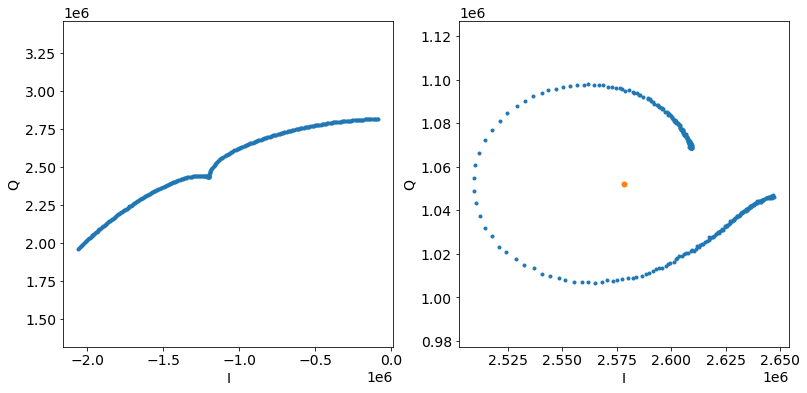

In [215]:
# test output
i=8

# Plot
fig,axs = plt.subplots(1,2,figsize=(13,6))

axs[0].plot(np.real(sw_iq[i]),np.imag(sw_iq[i]),'.')
axs[1].plot(np.real(circ_iq[i]),np.imag(circ_iq[i]),'.')
axs[1].plot(np.real(center[i]),np.imag(center[i]),'.',markersize=10)

for ax in axs:
    ax.axis('equal')
    ax.set_xlabel('I')
    ax.set_ylabel('Q')

plt.show()

In [11]:
def trans_rot(circ_iq,center):
    # translate the circularized data by xcen, and rotate by phase defined by xcen
    iq_out = []
    for i in range(len(circ_iq)):
        
        # translate first
        iq_trans = center[i] - circ_iq[i] # gao defines translation in this way
        
        # now rotate
        phi_trans = np.arctan2(np.imag(iq_trans),np.real(iq_trans))
        mag_trans = np.absolute(iq_trans)
        
        phi_cen = np.arctan2(np.imag(center[i]),np.real(center[i]))
    
        phi_out = phi_trans - phi_cen
        
        #phi_out = unwrap(phi_out) # unwrap about -pi to pi so the fit later sees continuous line
        ## Maybe I will simply unwrap before the fit, which I think is where it's most important
        ##  if I output IQ from this, it will just be wrapped again by arctan anyway
            
        # convert back to complex
        iq_out.append(mag_trans*np.cos(phi_out) + 1j*mag_trans*np.sin(phi_out))
        
    return np.array(iq_out)

In [207]:
# test output
iq = trans_rot(circ_iq,center)

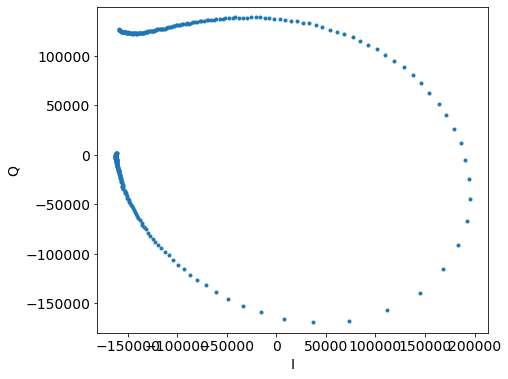

In [236]:
# test output
i=0

# Plot
fig,axs = plt.subplots(1,figsize=(7,6))
axs = [axs]

axs[0].plot(np.real(iq[i]),np.imag(iq[i]),'.')

for ax in axs:
    ax.axis('equal')
    ax.set_xlabel('I')
    ax.set_ylabel('Q')

plt.show()

In [12]:
def transform(freq_in,iq_in,slope,center):
    # This will apply the cicularization and translation+rotation
    # Want this to apply generally, so given params do the transformation. For the sweep data this might be a bit redundant
    #  since to get each of these params we do this step by step - so this might be more for just applying to final data.
    
## Actually, there is a bit more to conisder here about cable delay removal - the timestream data has only a single
##  freq which it is watched it, so will need to pass or handle freqs differently!
##  currently I think the whole phase - slope*f will work fine for array slope or single scalar slope, so just pass it
##  differently!

    iq_out = circularize(freq_in,iq_in,slope)
    iq_out = trans_rot(iq_out,center)
    
    return iq_out

In [13]:
def unwrap(phi_in): # maybe this can go in gao_fit fit?
    # I actually think to be safe the data being read in from timestreams should be unwrapped too since they are to be
    #  interpolated onto the sweep fit.
    
    wrap_crit = 3/2*np.pi # the criteria for how close to pi,-pi to consider that it has been wrapped
    
    phi_out = []
    for i in range(len(phi_in)):
        phi = phi_in[i]
    # for the fitting in next step, un wrap phi about -pi to pi since wrapping breaks the fit, check for discontinuity
        discont,k = False,0
        while not discont and k < len(phi)-2: # len -1 for 0 index and -1 more for k+1 used in loop
        # check for discontinuity
            if np.abs(phi[k+1] - phi[k]) > wrap_crit:
                discont = True
            k += 1 # I am relying on adding 1 even after discont found in next step
        if discont:
            means = np.array([np.mean(phi[:k]),np.mean(phi[k:])])
            #print(i,discont,means) ## for diagnostic
            if np.abs(means[0]) > np.abs(means[1]): # the left side needs to be wrapped
                if means[0] < 0: # left side on bottom, needs to be wrapped to top
                    phi[:k] = phi[:k] + 2*np.pi
                else: # on top, needs to be wrapped to bottom
                    phi[:k] = phi[:k] - 2*np.pi
            else: # assume only other case is opposite
                if means[1] < 0: # right side on bottom, needs to be wrapped to top
                    phi[k:] = phi[k:] + 2*np.pi
                else: # on top, needs to be wrapped to bottom
                    phi[k:] = phi[k:] - 2*np.pi
                    
            # need to put in a little extra check to see if some parts ended up being kicked too far the wrong way
            #  since the phase(f) can sometimes wiggle back to the other side of the line, and the above simply moves
            #  everything on one side of the discontinuity
            for m in range(len(phi)):
                if phi[m] > 2*np.pi: phi[m] = phi[m] - 2*np.pi
                if phi[m] < -2*np.pi: phi[m] = phi[m] + 2*np.pi
                    
                # this check is pretty ham fisted, but certainly seems to work at least.
    
        phi_out.append(phi)
    
    return np.array(phi_out)

In [332]:
# test output
phi_uw = unwrap(np.arctan2(np.imag(iq),np.real(iq)))

In [14]:
def gao_model(f,fr,qr,theta_0): # This is the model distribution for phase as func of freq used by Gao
    return -theta_0 + 2*np.arctan(2*qr*(1-f/fr))

In [15]:
def gao_fit(sw_freq,phi_uw): # this is really only to find f and phi at resonace, so depending on if we use
    #                           the freq from this fit as the reference, may not need it
    # Input unwrapped phi and freqs
    
    resref = [] # resonant point, f0,phi0
    for i in range(len(phi_uw)):
        popt,pcov = scipy.optimize.curve_fit(gao_model,sw_freq[i],phi_uw[i],p0=[sw_freq[i,150],1e3,0.0]) # again would like an estimator
                                                                                           #  to guess p0 better
        resref.append(np.array(popt[0],gao_model(popt[0],*popt))) # using the y pos that fr gives us,
                # rather than whatever business is up with Gao's use of theta_0 and some geometric relation.
    
    return np.array(resref)

In [249]:
# test output
resref = gao_fit(freq,phi_uw)

#print(resx)

In [16]:
def get_interp(freq_in,phi_uw):
    # Thinking of making this be just some cubic func - may need to be more complicated spline, but simpler the better
    #  for storing in a lookup table I think, unless scipy interpolate has a nice save/read function.
    # Pickle.dump seems like it can be used to save an object - ie a scipy function, but I need to save a batch of them
    #  in one place and be able to read it out easily - what's stopping me from pickling an array of interpolators
    #  now that I think about it?
    interp = []
    for i in range(len(freq_in)):
        # append interpolator func to the output
        interp.append(scipy.interpolate.interp1d(phi_uw[i],freq_in[i],kind='quadratic'))
    
    return np.array(interp) # array of interpolator function objects

In [335]:
# test output
interps = get_interp(freq,phi_uw)

In [338]:
# test output
print(interps[0](0.315))

868326232.927658


In [17]:
def save_params(outfile,kidno,slope,center,resref,interp): # save parameters, basically think I want to similarly pickle a dict kind of object like Elyssa did
    #outdict = {'kids':kidno,'delay_slope':slope,'center':center,'interpolator':interp} # now just save this!
    # actually it seems that npz already virtually saves as a dict like object with keywords as the array names
    
    # note that .npz will be appended automatically
    
    np.savez_compressed(outfile,kids=kidno,delay_slope=slope,center=center,resonant_ref=resref,interpolator=interp)

In [382]:
# test output
save_params('save_param_tst',kidno,slope,center,interps)
tstin = np.load('save_param_tst.npz')

In [386]:
# test output
print(tstin.files)

['kids', 'delay_slope', 'center', 'interpolator']


In [18]:
def read_params(infile): # read the correct params, which can then be passed into transform
    params_in = np.load(infile,allow_pickle=True)
    
    # break out and return the constituent arrays to be used
    return params_in['kids'],params_in['delay_slope'],params_in['center'],params_in['resonant_ref'],params_in['interpolator']

In [19]:
def read_timestream(infile):
    
    # read in the whole data set I think, and pick out the IQ and freqs, as above for the sweep
    # Hmm, I'll want to have some way to index by kid channel - or keep that stored alonge somewhere
    #  for reference later and for lableling, etc
    
    # Tyler's conversion is in a different structure to his conversion of the sweep reduc files, so of course
    #  .files doesn't work. What a pain. For now I will design to just use Elyssa's format. All this will change
    #  when the Roach goes away anyway. Her array names for the ts data are not byte strings, for some reason.
    
    # read data
    data_in = np.load(infile,allow_pickle=True,encoding='latin1') # extra args needed in case of Tyler's conversion
                                                                   # in case of Elyssa's, not needed
#### The .item thing is here to read tyler's conversion, need to add if statements like read_sweep!
    pytime = data_in['python_timestamp'] # just taking this timestamp of the various options
    freq = data_in['f0s'] # freq at which resonator observed
    
    Ikey = fnmatch.filter(data_in,'K*_I')
    Qkey = fnmatch.filter(data_in,'K*_Q')
    
    kidno = np.array([k.split('_')[0] for k in Ikey]) # get the channel labels
    
    ts_iq = []
    for i in range(len(Ikey)):
        # combine IQ into single complex number to fit form I have elsewhere
        ts_iq.append(data_in[Ikey[i]] + (1j*data_in[Qkey[i]]))
    
    return kidno,freq,pytime,np.array(ts_iq)

In [20]:
def get_dfof(freq,iq,resref,interp): # Called after transforming data, calculate dfof by interpolating
    
    phi = np.arctan2(np.imag(iq),np.real(iq))
    phi = unwrap(phi) # since func trained on unwrapped data, don't want any problems just in case.
    
    dfof = []
    for i in range(len(phi)):
        dfof.append((interp[i](phi[i]) - resref[0])/freq[i]) # change in freq = interp'd freq from current phase - ref freq
                                                         #  scaled by freq monitored at
    return np.array(dfof)

In [21]:
def save_dfof(outfile,kidno,time,dfof): # save the fully processed results
    
    np.savez_compressed(outfile,kids=kidno,time=time,dfof=dfof)

# Testing in general

Outline the whole pipeline to essentially build a main.

Changed to new file, more well behaved from march with 300 C BB as of Apr 18 to see if that cleans up the shit I'm looking at at all

In [25]:
# sweep file side
kidno,freq,sw_iq = read_sweep(path_srd)

slope = cable_fit(freq,sw_iq)
sw_iq = circularize(freq,sw_iq,slope)
center = get_center(sw_iq)
sw_iq = trans_rot(sw_iq,center)

phi = np.arctan2(np.imag(sw_iq),np.real(sw_iq)) # should make it so everything takes iq as arg, or at least unwrap does
phi_uw = unwrap(phi)
print(np.shape(phi))

resref = gao_fit(freq,phi_uw)
interp = get_interp(freq,phi_uw)

save_params('dfof_pipeline_tst',kidno,slope,center,resref,interp)

LinAlgError: Singular matrix

In [143]:
# timestream file side

kidno_sw,slope,center,resref,interp = read_params('dfof_pipeline_tst.npz')

kidno,freq,time,ts_iq = read_timestream("C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/converted_mar_2023/20230315_220325.npz")

iq = transform(freq,ts_iq,slope,center)

dfof = get_dfof(freq,iq,resref,interp)

Of course \_201944 is empty in the first batch of conversions from Elyssa, which will be the most informative one to look at. Ugh

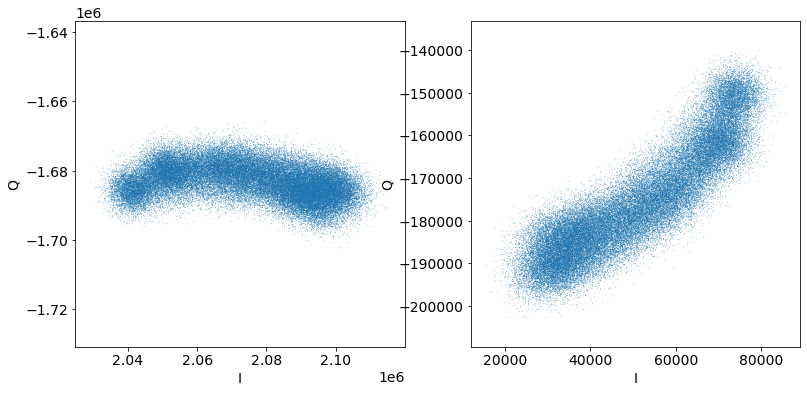

In [144]:
# Looking at the iq distribution, I was expecting it to be closer to the real line, but it seems expectedly confined
# to the origin near the peak. The curve is little changed by the transform since the initial iq loop is also well
#  confined.
i=6

# Plot
fig,axs = plt.subplots(1,2,figsize=(13,6))

axs[0].plot(np.real(ts_iq[i]),np.imag(ts_iq[i]),'.',markersize=.2)
axs[1].plot(np.real(iq[i]),np.imag(iq[i]),'.',markersize=.2)

for ax in axs:
    ax.axis('equal')
    ax.set_xlabel('I')
    ax.set_ylabel('Q')

plt.show()

Dec DATA :On the constant sweep data it seems like the transformation does certainly rotate the iq loop, but it is still out there at values of several million with no 0 in sight. Is this actually an issue or not though? Shouldn't the thing still be fairly well seperated between top and bottom of chop?

Looking below I see almost no variation in the top profile, it's all in the bottom, and get's nowhere near to 0 difference like I would expect from the kludge method. I would expect them to have similar to the same shape.

These artificial looking super hard cuts in the horizontal, and fact that it looks like one could infer a peak is flipped about them or something leads me to belive there is probably an error somewhere in my application of finding dfof.
* Check that correct reference f is used
* check on if there is any issue stemming from wrapping

Cont Apr 18. Tyler thinks part of this might just be that the data is funky rather than all just my code. And indeed some of these like channel 2 work totally perfectly. I was thinking that the issue had to do with how well rotated and aligned the IQ loop from the timestream was. As can be seen that we'd expect the transformed TS data to align fairly nicely vertically near resonance, but it does not. And there is no correlation between how well rotated things are, chan 2 is, but many other channels that are nicely rotated do not align such. Maybe it is just the data in the end . . .

Trying with march data and the 300 C BB, the shit in the end looks like it is totally clean when df/f is produced. The rotation above is still not exactly expectations at all, but maybe that's just fine? The thing to do would be to just plot the phase or freq itself, or maybe just the iq, alongside that from the sweep and see how they align.

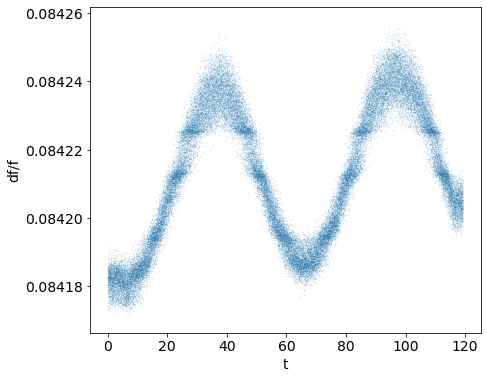

In [139]:
fig,axs = plt.subplots(1,1,figsize=(7,6))
axs = [axs]
axs[0].plot(time-time[0],dfof[i],'.',markersize=.1)

for ax in axs:
    ax.set_xlabel('t')
    ax.set_ylabel('df/f')

plt.show()

# Testing for interpolation function

In [265]:
def cubic(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

Cubic is definitely out! The legs asymptote made quick, I mean it's a tangent func after all. It seems like gao's model which fit arctan to the original wasn't always on point either, so I doubt a tan model will be perfect at capturing the shape. Once more I think there's an arg that we *should* be close enough to the linear regime near phi=0 in the sweep anyway that we might only care about that small region before it begins to straighten out where the arctan model did fit relatively well anyway. Although at least on this hight T BB test data which isn't that well behaved, it isn't exactly that great of a fit in that region for over half of the channels.

In [274]:
def tangen(x,A,w,d,c):
    return A*np.tan(w*x + d) + c

This struggles mad bad too, seems to probably also be super sensitive to initial conditions, so this is basically just a fail. Think I will need to either just invert Gao's model - which is a pretty solid no on doing since it doesn't fit that well - or I need to just bite the bullet and hit it with a scipy interpolate spline.

### Univariate Spline

Using this method instead of interp 1d since it has a smoothing factor, but no matter how far I crank it up it won't not visit the point that got kicked out by the unwrapping in channel 1. This also has an annoying constraint that x must be sorted for it to work since this is inverted and fucked with it isn't necessarily the case that phi is monotonic increase. That isn't so hard to deal with, but I do want a certain amount of smoothing to go down here yaknow.

I could and probably should just make a little check to hack off the outliers before fitting, for either this or interp1d

Channel 6 is somehow just fuckered bad unless I put the smoothing way up. It places something on the LHS down at like y = 6e-12 where the data is living at 8e8. Gives warning about s being too small, even if left at the default. Increasing it just gives more warnings until eventually it doesn't like s=1e9. s=1e6 still produced the issue, but sending off way positive. Need to find out why it is tripping like that for only one end of one channel, or just use interp1d.

Realistically, to fix much of this stuff I could just hack off the like 100+ points at the super dense extents of the distribution without really losing anything.

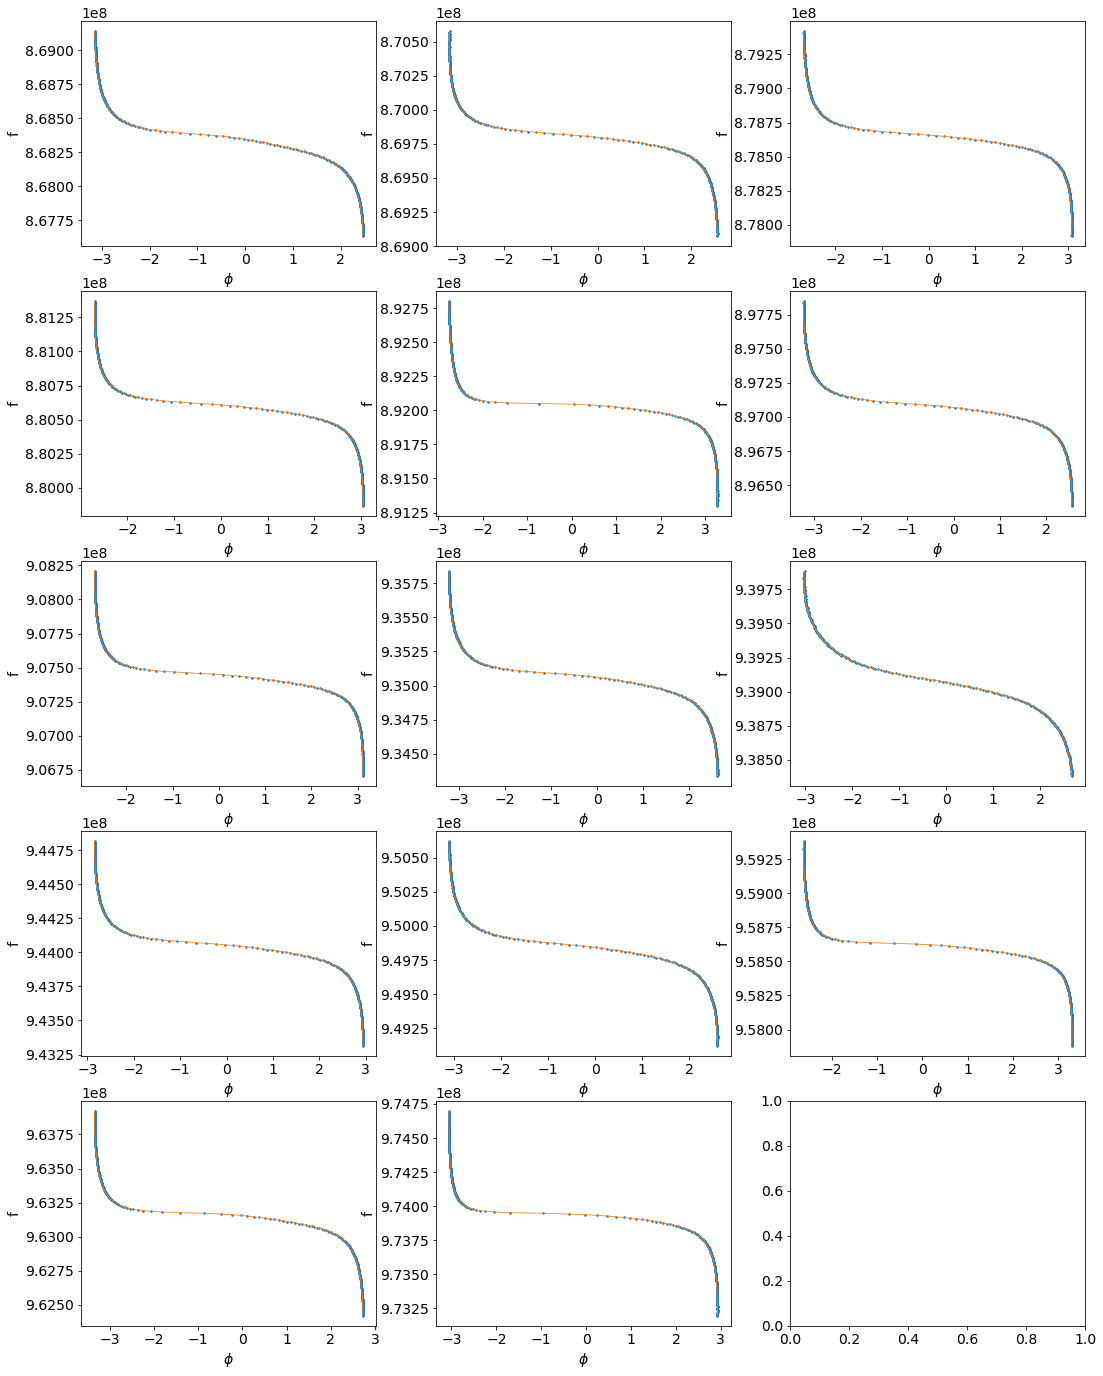

In [333]:
# loop to operate and perform fit
row,col = 5,3

fig,axs = plt.subplots(row,col,figsize=(18,24))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        if not (i==4 and j==2):
            k = col*i + j
            
            # effectively invert function by swapping x,y inputs, and fit
            #  for univariate spline need to set x to be strictly increasing, where it is not guaranteed to be here
            #  apparently.
            ind = np.argsort(phi_uw[k])
            interp = scipy.interpolate.interp1d(phi_uw[k][ind],freq[k][ind],kind='quadratic')
            # plots
            axs[i,j].plot(phi_uw[k],freq[k],'.',markersize=3)
            axs[i,j].plot(phi_uw[k],interp(phi_uw[k]),lw=0.8)
            

            #axs[i,j].axis('equal')
            axs[i,j].set_xlabel('$\phi$')
            axs[i,j].set_ylabel('f')

plt.show()

# Testing better circle fit algorithms

Mainly the one from the very handy scipy article

In [80]:
kidno,freq,sw_iq = read_sweep(path_srd)

slope = cable_fit(freq,sw_iq)
circ_iq = circularize(freq,sw_iq,slope)
#kk = 0
#center,elliparams = get_center(circ_iq[kk:],kidno[kk:],full_output=True)

center = get_center_simple(circ_iq)

trans_iq = trans_rot(circ_iq,center)

In [72]:
print(np.shape(elliparams))

(0,)


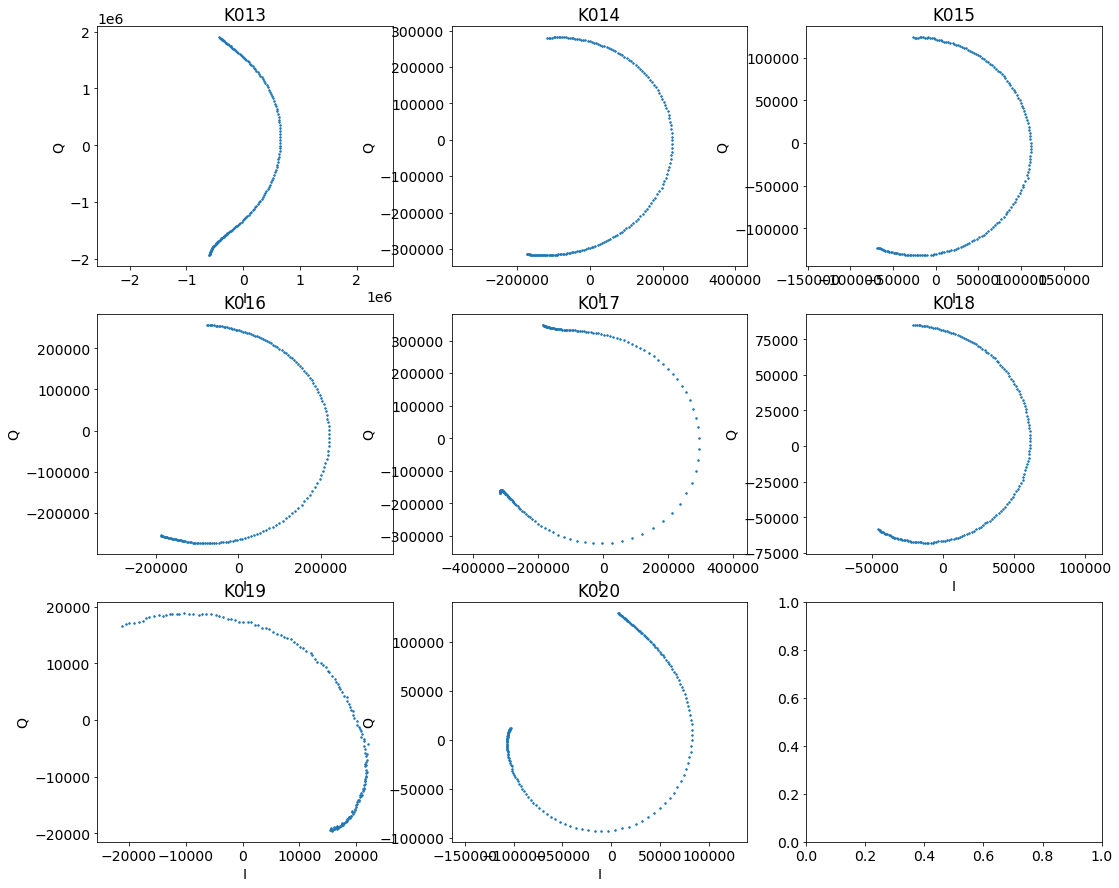

In [81]:
# loop to operate and perform fit
row,col = 3,3

fig,axs = plt.subplots(row,col,figsize=(18,5*row))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        if not (i>=2 and j>=2):
            k = col*i + j
            
            # plots
            axs[i,j].plot(np.real(trans_iq[k]),np.imag(trans_iq[k]),'.',markersize=3) # data
            
            #x,y = get_ellipse_pts(elliparams[k]) # plot the fitted ellipse
            #axs[i,j].plot(x,y)
            #axs[i,j].plot(elliparams[k][0],elliparams[k][1],'.') # plot the fitted centers
            
            #axs[i,j].plot(np.real(center[k]),np.imag(center[k]),'.') # plot the centers

            axs[i,j].axis('equal')
            axs[i,j].set_title(kidno[k])
            axs[i,j].set_xlabel('I')
            axs[i,j].set_ylabel('Q')

plt.show()

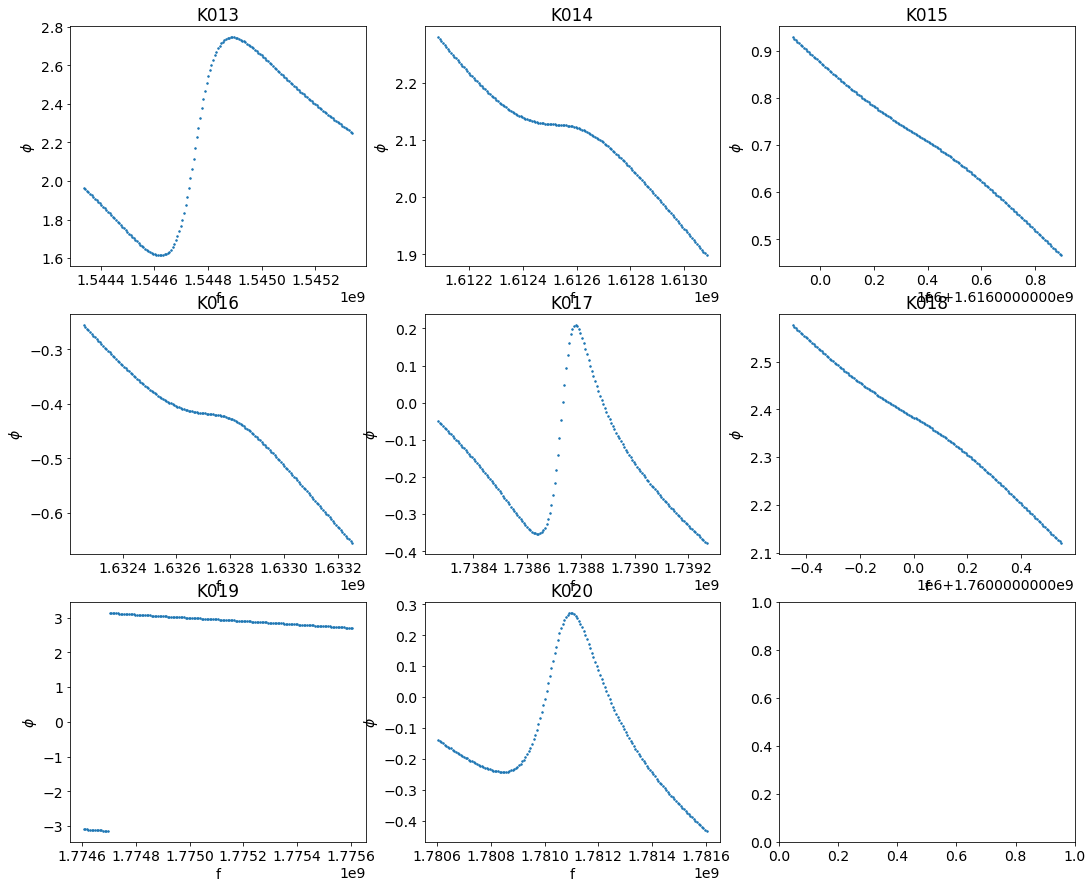

In [79]:
# Testing the phase(f) of this input data

row,col = 3,3

fig,axs = plt.subplots(row,col,figsize=(18,5*row))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        if not (i>=2 and j>=2):
            k = col*i + j
            
            # plots
            axs[i,j].plot(freq[k],np.arctan2(np.imag(sw_iq[k]),np.real(sw_iq[k])),'.',markersize=3) # data
            
            axs[i,j].set_title(kidno[k])
            axs[i,j].set_xlabel('f')
            axs[i,j].set_ylabel('$\phi$')

plt.show()

In [148]:
cent = elliparams[:,0] + 1j*elliparams[:,1]
cent_old = get_center_simple(sw_iq)

trans_iq = trans_rot(sw_iq,cent)

NameError: name 'trans_iq' is not defined

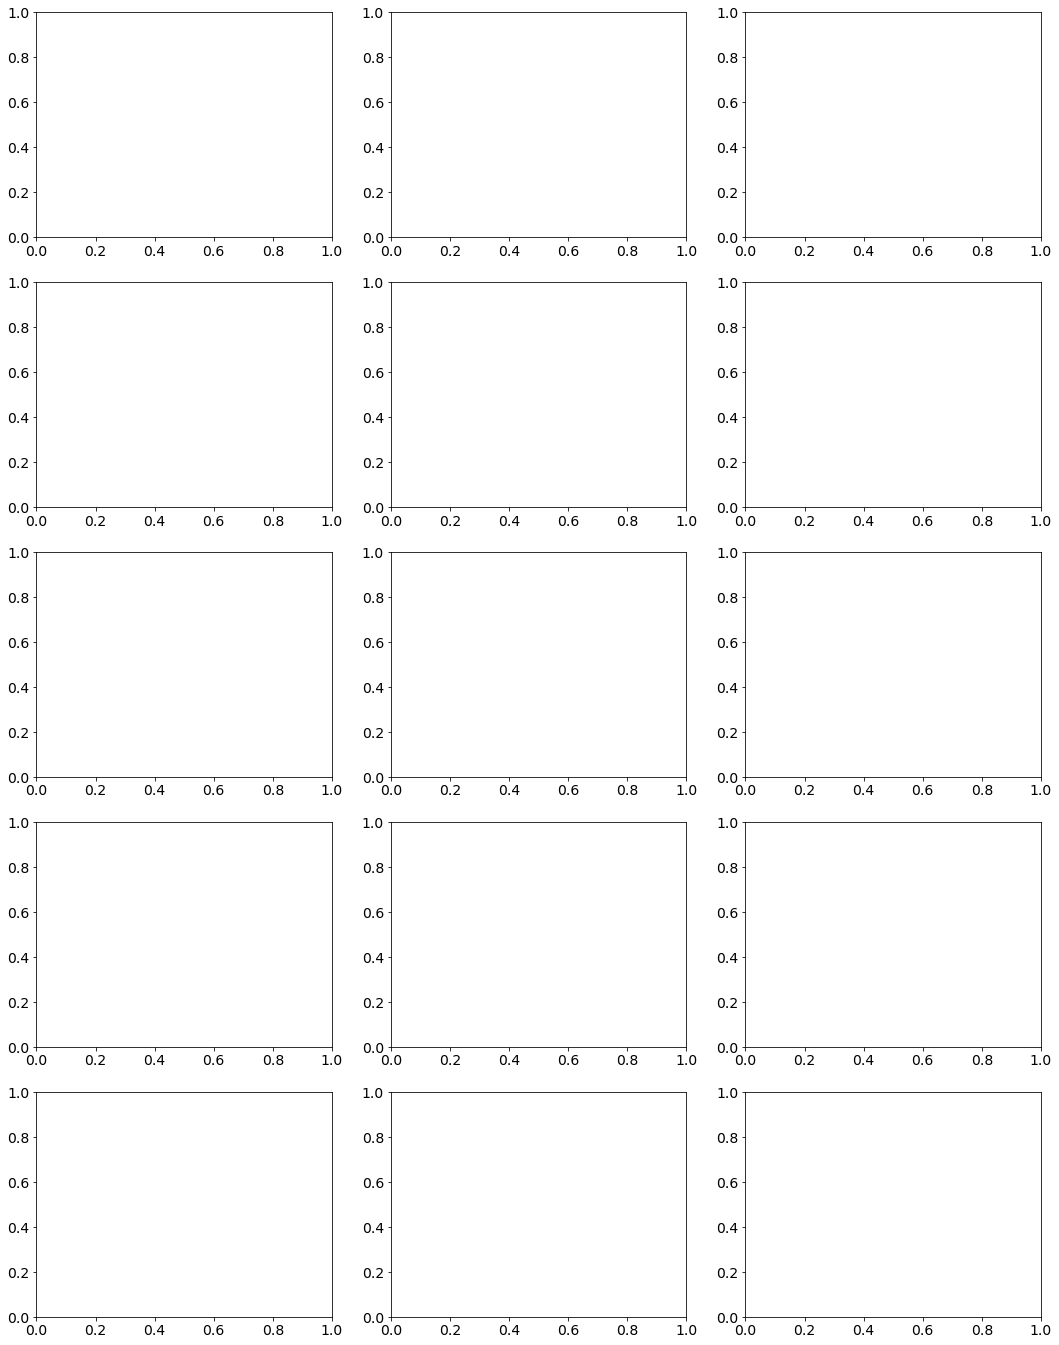

In [29]:
# translate and rotate by the fitted center point.
row,col = 5,3

fig,axs = plt.subplots(row,col,figsize=(18,24))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        if not (i==4 and j>=1):
            k = col*i + j
            
            # plots
            axs[i,j].plot(np.real(trans_iq[k]),np.imag(trans_iq[k]),'.',markersize=3) # translated and rotated 

            axs[i,j].axis('equal')
            axs[i,j].set_xlabel('I')
            axs[i,j].set_ylabel('Q')

plt.show()

Wow, this does absolutely no better or worse at all in terms of the final rotation than the basic method of finding the max exetents (damn near indistinguishable)! I guess to some degree that is not shocking since these things are out at large r, so small changes in the center postion really lead to minute changes in the phase. Well, what now?

The ellipse fit is still damn quick and robust, so makes good sense to keep it moving forward. There are more flexible options in it, such as reporting the center as the center fit plus some ratio of the major axis, etc. But given that small changes are unlikely to do much of anything, I'm not sure that will do anything.

Makes me wonder, is it reasonable to change the magnitude of the input iq so we get more resolution on the phase angle before the fit used for rotation or something? Basically a 2 stage translation?

On switch from the old december data to march data with lower BB temp (1000 C to 300C), it seems that things are no better aligned in terms of rotation really. The data just behaves better stright up regardless.

# So, I have df/f now. On to the next.

I have placed these functions into a module called iq2df